In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk/credit_risk_dataset.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
original = pd.read_csv('/kaggle/input/credit-risk/credit_risk_dataset.csv')

In [3]:
print(train.shape)
print(test.shape)
print(original.shape)

(58645, 13)
(39098, 12)
(32581, 12)


In [4]:
train.loan_status.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [5]:
original.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
# concatenate train and original datasets and explore data

train_origin = pd.concat([train, original], axis=0, ignore_index=True)
train_origin.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0.0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1.0,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2.0,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3.0,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4.0,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [7]:
train_origin['loan_status'].value_counts()

loan_status
0    75768
1    15458
Name: count, dtype: int64

In [8]:
imbalanced_ratio = train_origin['loan_status'].value_counts()[1] / train_origin['loan_status'].value_counts()[0]
imbalanced_ratio

0.20401752718825888

The imbalanced ratio of approximately 0.204 indicates that the dataset has a imbalance between the two classes of loan status. The model may face some challenges in accurately predicting the minority class.

In [9]:
# drop id column, it is uneccessery column
train_origin = train_origin.drop('id', axis=1)

In [10]:
train_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.4+ MB


In [11]:
train_origin.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91226.000000,9.122600e+04,90331.000000,91226.000000,88110.000000,91226.000000,91226.000000,91226.000000
mean,27.616480,6.477071e+04,4.732119,9350.348607,10.789508,0.163154,5.810219,0.169447
std,6.148115,4.793696e+04,4.025068,5848.605423,3.108998,0.097491,4.038412,0.375149
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.950000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


Some applicants as old as 144, indicating potential outliers or data inaccuracies. The same with employment length.

In [12]:
train_origin.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,91226,91226,91226,91226
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,47040,18724,31761,76779


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

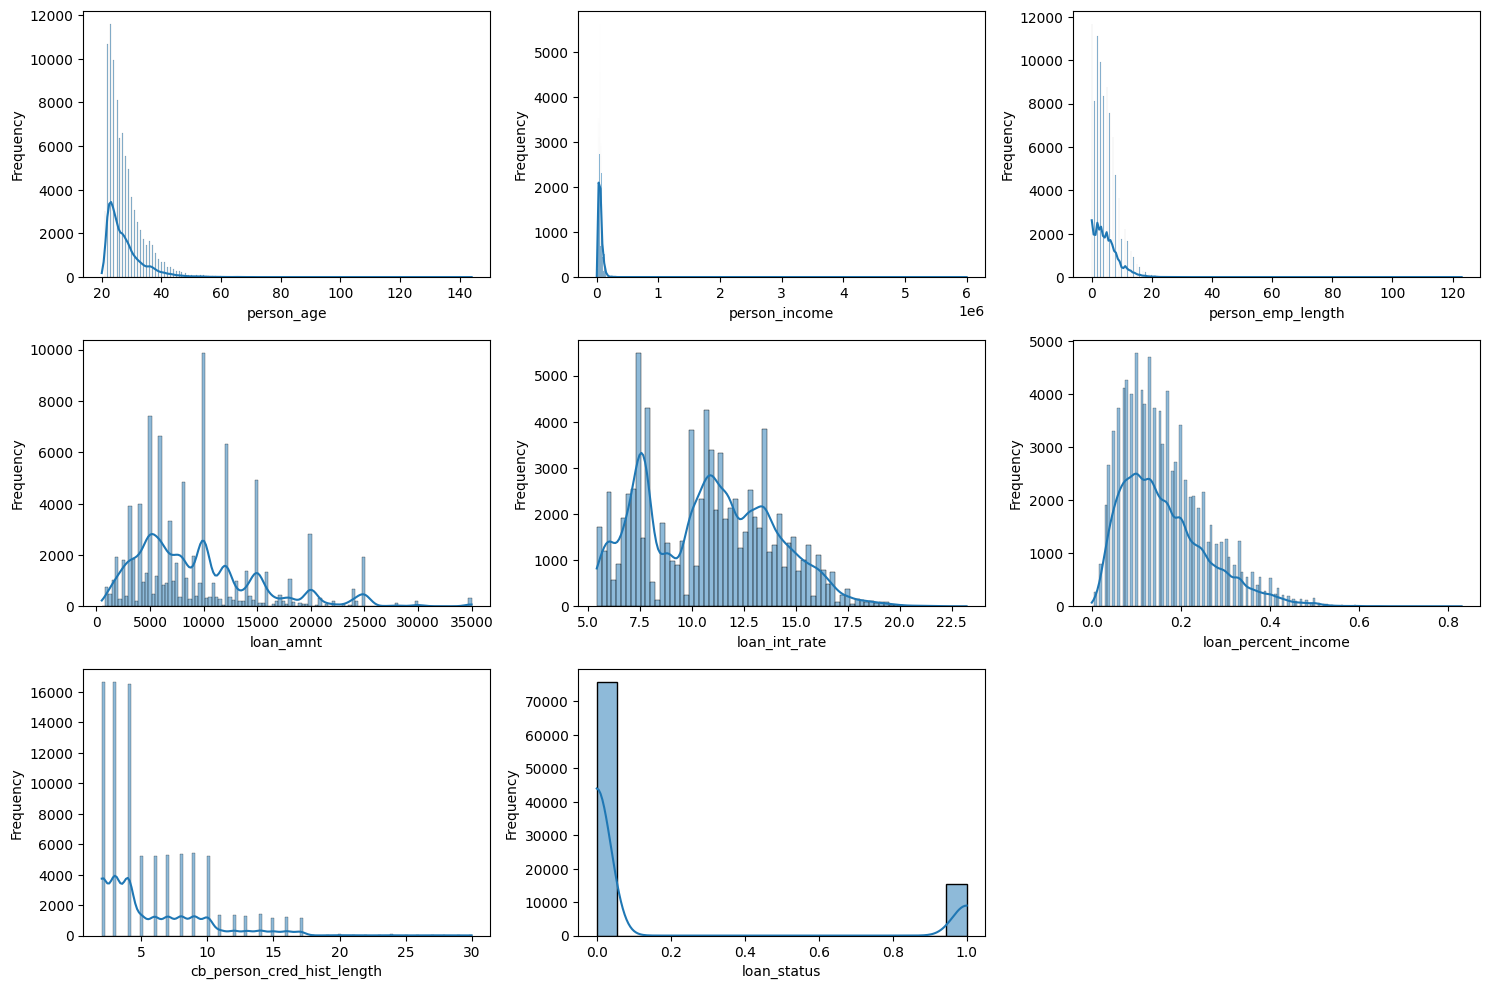

In [13]:
numerical_features = train_origin.select_dtypes(include=['number'])

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_origin[feature], kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [14]:
numerical_features.corrwith(numerical_features.loan_status).abs().sort_values(ascending=False)[1:]

loan_percent_income           0.381631
loan_int_rate                 0.339932
person_income                 0.152001
loan_amnt                     0.130323
person_emp_length             0.091718
person_age                    0.008058
cb_person_cred_hist_length    0.008049
dtype: float64

<Axes: >

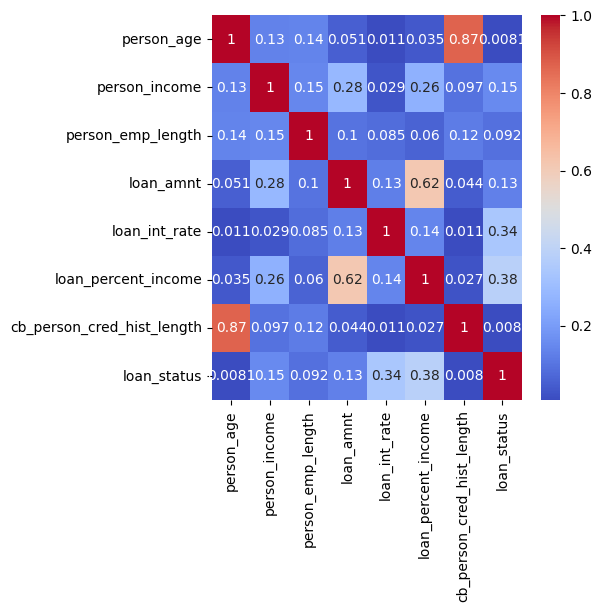

In [15]:
plt.figure(figsize=(5, 5))
corr_data = numerical_features.corr().abs()
sns.heatmap(corr_data, annot=True, cmap='coolwarm')

**High correlation between person_age and cb_person_cred_hist_length:**
There is a strong positive correlation (0.87) between person_age and cb_person_cred_hist_length. This makes sense as the length of a person’s credit history is likely to increase with age.

**Moderate correlations involving loan_percent_income:**
loan_percent_income has a moderate positive correlation (0.62) with loan_amnt, indicating that higher loan amounts often represent a higher percentage of a person's income.

In [16]:
categorical_features = train_origin.select_dtypes(include=['object'])
res = {}
for column in categorical_features.columns:
    res[column] = categorical_features[column].unique()
res

{'person_home_ownership': array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object),
 'loan_intent': array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
        'HOMEIMPROVEMENT'], dtype=object),
 'loan_grade': array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object),
 'cb_person_default_on_file': array(['N', 'Y'], dtype=object)}

In [17]:
loan_grade_group = train_origin.groupby(['loan_grade'])['loan_status'].agg(['count', 'mean'])
loan_grade_group

,count,mean
loan_grade,,
A,31761,0.066276
B,30851,0.122784
C,17494,0.161941
D,8660,0.592263
E,1973,0.634567
F,390,0.669231
G,97,0.927835


97 persons  with grade 'G' has 92% of loan_staus (1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='loan_grade', ylabel='Count'>

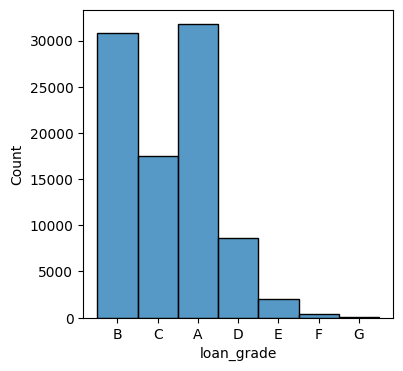

In [18]:
plt.figure(figsize=(4, 4))
sns.histplot(train_origin['loan_grade'])

In [19]:
loan_intent_group = train_origin.groupby(['loan_intent'])['loan_status'].agg(['count', 'mean'])
loan_intent_group

,count,mean
loan_intent,,
DEBTCONSOLIDATION,14345,0.224399
EDUCATION,18724,0.129940
HOMEIMPROVEMENT,9885,0.205564
MEDICAL,17005,0.209938
PERSONAL,15537,0.156272
VENTURE,15730,0.112905


In [20]:
person_home_ownership_group = train_origin.groupby(['person_home_ownership'])['loan_status'].agg(['count', 'mean'])
person_home_ownership_group

,count,mean
person_home_ownership,,
MORTGAGE,38268,0.082915
OTHER,196,0.244898
OWN,5722,0.041244
RENT,47040,0.255123


The majority of borrowers fall into the "RENT" category (47,040), followed by "MORTGAGE" (38,268), "OWN" (5,722), and a small number in "OTHER" (196). This distribution suggests that a large segment of the loan applicants are renting their homes.

In [21]:
cb_person_default_on_file_group = train_origin.groupby(['cb_person_default_on_file'])['loan_status'].agg(['count', 'mean'])
cb_person_default_on_file_group

,count,mean
cb_person_default_on_file,,
N,76779,0.139166
Y,14447,0.330380


The majority of borrowers in the dataset do not have a default on file, with 76,779 individuals in the "N" (No) category, compared to 14,447 in the "Y" (Yes) category. This suggests that a significant portion of the applicants have a clean credit history.

In [22]:
# all persons older then 80 have loan_status (0)
train_origin[train_origin['person_age'] > 80]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
4962,84,108928,MORTGAGE,3.0,DEBTCONSOLIDATION,A,6000,7.51,0.06,N,25,0
6750,84,94800,MORTGAGE,2.0,PERSONAL,D,10000,14.09,0.11,N,22,0
47336,123,36000,MORTGAGE,7.0,PERSONAL,B,6700,10.75,0.18,N,4,0
58726,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3,0
58828,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0.03,N,2,0
59220,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3,0
59392,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0.26,N,4,0
90942,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25,0
91061,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0.27,N,27,0
91151,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0.11,N,24,0


In [23]:
# drop persons with age more then 80
train_origin = train_origin.drop(train_origin[train_origin['person_age'] > 80].index)

In [24]:
train_origin[(train_origin['person_emp_length'] > 30) & (train_origin['person_age'] < 50)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
24214,43,50000,RENT,35.0,DEBTCONSOLIDATION,A,9000,5.42,0.18,N,16,0
26125,43,56000,RENT,41.0,HOMEIMPROVEMENT,B,2000,10.99,0.04,N,14,0
29271,47,53913,MORTGAGE,31.0,HOMEIMPROVEMENT,B,7000,10.71,0.13,N,13,1
39112,46,84000,MORTGAGE,31.0,HOMEIMPROVEMENT,D,20000,17.49,0.24,N,8,0
41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1
48287,48,70000,MORTGAGE,31.0,HOMEIMPROVEMENT,A,9000,8.94,0.13,N,8,0
49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0
52038,38,42000,MORTGAGE,31.0,VENTURE,B,11000,11.49,0.26,N,14,0
53832,46,52000,MORTGAGE,31.0,VENTURE,B,10000,9.91,0.19,N,16,0
58645,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1


The employment length of 123 years for individuals aged 21 to 28 is clearly unrealistic, suggesting data entry errors or anomalies and some clients have difference between age and length of the employment less then 18 year

In [25]:
train_origin[(train_origin['loan_status'] == 0) & (train_origin['person_age'] - train_origin['person_emp_length'] < 0)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.1,N,2,0
58855,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0.1,N,4,0


In [26]:
indices_to_drop = train_origin.index[(train_origin['loan_status'] == 0) & 
                                      (train_origin['person_age'] - train_origin['person_emp_length'] < 0)]
train_origin = train_origin.drop(indices_to_drop)

In [27]:
train_origin[train_origin['person_emp_length'] == 123]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1
58645,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1


In [28]:
median_emp_length_22 = train_origin[train_origin['person_age']== 22]['person_emp_length'].median()
# Replace person_emp_length with the median value for age 22
train_origin.loc[train_origin['person_age'] == 22, 'person_emp_length'] = median_emp_length_22

median_emp_length_28 = train_origin[train_origin['person_age']== 28]['person_emp_length'].median()
# Replace person_emp_length with the median value for age 28
train_origin.loc[train_origin['person_age'] == 28, 'person_emp_length'] = median_emp_length_28

In [29]:
# treshhold to separate train_df and test_df
limit = train_origin.shape[0]
limit

91214

In [30]:
test = test.drop('id', axis=1)

In [31]:
df = pd.concat([train_origin, test], axis=0, ignore_index=True)

In [32]:
df.shape

(130312, 12)

In [33]:
100 * (train_origin.isna().sum()/len(test)).sort_values(ascending=False)

loan_int_rate                 7.964602
person_emp_length             1.872219
person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
loan_status                   0.000000
dtype: float64

**Fill missing values, with median**

In [34]:
df['person_emp_length']  = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate']  = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

In [35]:
df.isna().sum()

person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length                 0
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                     0
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
loan_status                   39098
dtype: int64

**Create new additional feature**

In [36]:
#Debt-to-Income Ratio
df['dti'] = df['loan_amnt'] / df['person_income']

#Employment Stability
df['emp_stability'] = df['person_emp_length'].apply(lambda x: 1 if x > 5 else 0)

#Home Ownership Binary Feature
def cred_hist_category(cred_hist_length):
    if cred_hist_length < 5:
        return 'short_history'
    elif 5 <= cred_hist_length <= 10:
        return 'medium_history'
    else:
        return 'long_history'

df['cred_hist_category'] = df['cb_person_cred_hist_length'].apply(cred_hist_category)


In [37]:
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,dti,emp_stability,cred_hist_category
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0,0.171429,0,long_history
1,22,56000,OWN,4.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0,0.071429,0,short_history
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0,0.208333,1,medium_history


In [38]:
#df_encoded = pd.get_dummies(df, drop_first=True, dtype='int')
loan_grade_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
cb_person_default_on_file_dict = {'N': 0, 'Y':1}
cred_hist_category_dict = {'long_history': 0, 'medium_history': 1, 'short_history': 2}
person_home_ownership_dict = {'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}
loan_intent_dict = {'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}

df['loan_grade'] = df['loan_grade'].map(loan_grade_dict)
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map(cb_person_default_on_file_dict)
df['person_home_ownership'] = df['person_home_ownership'].map(person_home_ownership_dict)
df['loan_intent'] = df['loan_intent'].map(loan_intent_dict)
df['cred_hist_category'] = df['cred_hist_category'].map(cred_hist_category_dict)

In [39]:
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,dti,emp_stability,cred_hist_category
0,37,35000,0,0.0,0,1,6000,11.49,0.17,0,14,0.0,0.171429,0,0
1,22,56000,2,4.0,1,2,4000,13.35,0.07,0,2,0.0,0.071429,0,2
2,29,28800,2,8.0,2,0,6000,8.90,0.21,0,10,0.0,0.208333,1,1


In [40]:
train_df = df.iloc[:limit, :]
test_df = df.iloc[limit:, :]

In [41]:
train_df.shape

(91214, 15)

In [42]:
y = train_df['loan_status']
X = train_df.drop('loan_status', axis=1)

**RandomForestClassifier**

In [43]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)  # 5-fold cross-validation

# Model to train
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)


# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_rf.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_prob = model_rf.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


0.9380980591539221
0.9393319518400496
0.9503575178477155
0.9174529870626209
0.9221287331598454
Average AUC: 0.9335


**XGBoostClassifier**

In [44]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)  # 5-fold cross-validation

# Model to train
model_xgb = xgb.XGBClassifier(
    scale_pos_weight=4,  # Adjust this based on imbalance ratio
    use_label_encoder=False,  # Avoids label encoding warning
    eval_metric='auc',  # Use AUC as the evaluation metric
    random_state=42
)


# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_xgb.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_prob = model_xgb.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


0.9566834679795585
0.9575649116701276
0.9604510262922031
0.9431779166908234
0.9377525597436148
Average AUC: 0.9511


**CatBoostClassifier**

In [45]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)  # 5-fold cross-validation

# Model to train
model_cat = CatBoostClassifier(
    iterations=1000,             # Number of boosting iterations
    learning_rate=0.1,           # Learning rate
    depth=4,                     # Depth of the trees
    class_weights=[1, 4],        # Adjust class weights (example: 1 for majority, 4 for minority)
    eval_metric='AUC',           # Use AUC as the evaluation metric
    random_seed=42,
    verbose=100                  # Print progress every 100 iterations
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_cat.fit(X_train, y_train, verbose=False)
    
    # Get predicted probabilities for the positive class
    y_prob = model_cat.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


0.9605445152445513
0.961959461472919
0.9649998872924164
0.944897262341331
0.9446410288270085
Average AUC: 0.9554


**LGBMClassifier**

In [46]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)  # 5-fold cross-validation

# Model to train
model_lgb = lgb.LGBMClassifier(
    n_estimators=1000,            # Number of boosting iterations
    learning_rate=0.1,            # Learning rate
    max_depth=4,                  # Depth of the trees
    class_weight='balanced',      # Automatically adjust weights for class imbalance
    random_state=42,
    verbose=-1
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_lgb.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_prob = model_lgb.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


0.9603276253878735
0.9625203204515681
0.965249957243695
0.9468397177767951
0.9410744520473839
Average AUC: 0.9552


**GradientBoostingClassifier**

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)  # 5-fold cross-validation

# Model to train
model_grb = GradientBoostingClassifier(
    n_estimators=1000,            # Number of boosting iterations
    learning_rate=0.1,            # Learning rate
    max_depth=4                 # Depth of the trees
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_grb.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_prob = model_grb.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC for fold: {auc:.4f}")
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


AUC for fold: 0.9627
AUC for fold: 0.9642
AUC for fold: 0.9666
AUC for fold: 0.9488
AUC for fold: 0.9451
Average AUC: 0.9575


In [48]:
model_cat = CatBoostClassifier(
    iterations=1497,
    learning_rate=0.19862700515892123,
    depth=3,
    class_weights={0: 1, 1: 2.8609507839857535},  # Example of giving more weight to the minority class
#    cat_features=cat_features,
    border_count = 241,
    eval_metric='AUC',           # Use AUC as the evaluation metric
    random_seed=42,
    verbose=100
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model_cat.fit(X_train, y_train)
    
    # Get predicted probabilities for the positive class
    y_prob = model_cat.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


0:	total: 10.7ms	remaining: 15.9s
100:	total: 1.05s	remaining: 14.5s
200:	total: 2.07s	remaining: 13.3s
300:	total: 3.09s	remaining: 12.3s
400:	total: 4.12s	remaining: 11.3s
500:	total: 5.19s	remaining: 10.3s
600:	total: 6.27s	remaining: 9.35s
700:	total: 7.32s	remaining: 8.31s
800:	total: 8.66s	remaining: 7.52s
900:	total: 9.89s	remaining: 6.54s
1000:	total: 10.9s	remaining: 5.4s
1100:	total: 11.9s	remaining: 4.3s
1200:	total: 13s	remaining: 3.2s
1300:	total: 14s	remaining: 2.11s
1400:	total: 15s	remaining: 1.03s
1496:	total: 16.1s	remaining: 0us
0.9604129892042743
0:	total: 10.6ms	remaining: 15.9s
100:	total: 1.06s	remaining: 14.7s
200:	total: 2.1s	remaining: 13.6s
300:	total: 3.13s	remaining: 12.4s
400:	total: 4.14s	remaining: 11.3s
500:	total: 5.16s	remaining: 10.3s
600:	total: 6.2s	remaining: 9.24s
700:	total: 7.21s	remaining: 8.19s
800:	total: 8.22s	remaining: 7.14s
900:	total: 9.24s	remaining: 6.11s
1000:	total: 10.3s	remaining: 5.12s
1100:	total: 11.4s	remaining: 4.09s
1200:	to

                       Feature  Importance
1                person_income   24.048616
5                   loan_grade   14.786409
11                         dti   14.727852
8          loan_percent_income   11.451784
4                  loan_intent   11.159098
2        person_home_ownership    9.238654
7                loan_int_rate    5.569580
0                   person_age    3.187504
3            person_emp_length    2.440435
6                    loan_amnt    2.354831
10  cb_person_cred_hist_length    0.719753
13          cred_hist_category    0.202942
9    cb_person_default_on_file    0.072479
12               emp_stability    0.040063


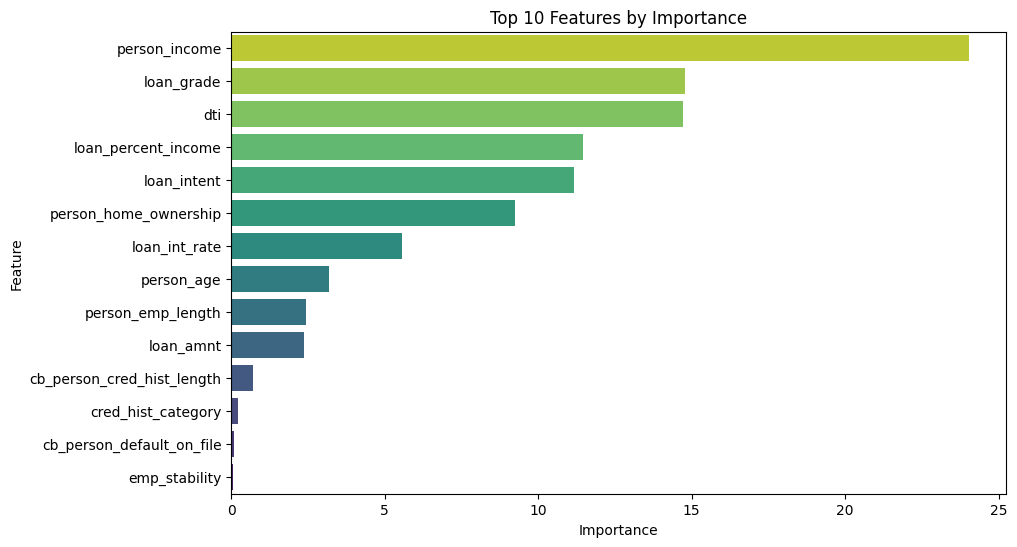

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = model_cat.get_feature_importance()

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=True), palette='viridis')
plt.xlabel('Importance')
plt.title('Top 10 Features by Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


Optuna to find best hyperparametrs of model

In [50]:
# import pandas as pd
# import optuna
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_auc_score

# # Assuming X and y are your features and target variable
# # Define StratifiedKFold
# skf = StratifiedKFold(n_splits=5)

# # Define the objective function for Optuna
# def objective(trial):
#     # Suggest hyperparameters
#     n_estimators = trial.suggest_int('n_estimators', 50, 1000)  # Number of boosting iterations
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)  # Learning rate
#     max_depth = trial.suggest_int('max_depth', 3, 6)  # Depth of the trees
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Minimum samples to split a node
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)  # Minimum samples in leaf node

#     # Model to train
#     model_grb = GradientBoostingClassifier(
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=42
#     )

#     # List to store AUC scores
#     auc_scores = []

#     # Cross-validation process
#     for train_index, test_index in skf.split(X, y):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         # Train the model
#         model_grb.fit(X_train, y_train)

#         # Get predicted probabilities for the positive class
#         y_prob = model_grb.predict_proba(X_test)[:, 1]

#         # Calculate AUC
#         auc = roc_auc_score(y_test, y_prob)
#         auc_scores.append(auc)

#     # Return the average AUC score across all folds
#     return sum(auc_scores) / len(auc_scores)

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')  # We want to maximize AUC

# # Optimize the hyperparameters
# study.optimize(objective, n_trials=100)  # Number of trials to perform

# # Print the best hyperparameters and AUC score
# print("Best hyperparameters: ", study.best_params)
# print("Best AUC score: ", study.best_value)


In [51]:
test_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,dti,emp_stability,cred_hist_category
91214,23,69000,0,3.0,5,5,25000,15.76,0.36,0,2,NaN,0.362319,0,2
91215,26,96000,1,6.0,2,2,10000,12.68,0.10,1,4,NaN,0.104167,1,2
91216,26,30000,0,5.0,3,4,4000,17.19,0.13,1,2,NaN,0.133333,0,2
91217,33,50000,0,4.0,4,0,7000,8.90,0.14,0,7,NaN,0.140000,0,1
91218,26,102000,1,8.0,5,3,15000,16.32,0.15,1,4,NaN,0.147059,1,2


In [52]:
test_df = test_df.drop('loan_status', axis=1)

In [53]:
test_predictions = model_cat.predict_proba(test_df)[:, 1]

In [54]:
test_predictions

array([0.99995807, 0.09253613, 0.81645102, ..., 0.02533474, 0.62942774,
       0.98394892])

In [55]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = test_predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,id,loan_status
0,58645,0.999958
1,58646,0.092536
2,58647,0.816451
3,58648,0.022231
4,58649,0.199219
